In [32]:
from Utilities.utils import read_data
from Utilities import plot_settings

In [3]:
url = 'https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt'
raw, names = read_data(url)

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ML\GammaRayBursts\Utilities\utils.py:21: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [4]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [53]:
T90, F, RS, T100 = zip(*[(float(a), float(b), float(c), float(d)) for a, b, c, d in zip(raw[6], raw[9], raw[11], raw[12]) 
                                           if a != '-999' and float(a) !=0
                                           and b != '-999' and float(b) != 0
                                           and c != '-999' and float(c) != 0
                                           and d != '-999' and float(d) != 0
                                           ])

In [54]:
import numpy as np

In [55]:
T90 = np.array(T90)
F = np.array(F)
T100 = np.array(T100)
RS = np.array(RS)

In [56]:
from sklearn.preprocessing import StandardScaler

In [57]:
scaler = StandardScaler()

In [65]:
X = np.vstack([T90, T100, F, RS]).T

In [66]:
X_scaled = scaler.fit_transform(X)

In [67]:
from sklearn.decomposition import PCA

In [68]:
pca = PCA(n_components=4)

In [69]:
pca.fit(X_scaled)

PCA(n_components=4)

In [70]:
vals = pca.transform(X_scaled)
mean = pca.mean_
vecs = pca.components_

In [71]:
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Expained fractional variance of data encapsulated in the eigenvalues: [0.51138858 0.25511029 0.22574121 0.00775992]


In [72]:
import matplotlib.pyplot as plt

Text(0.5, 0, '$\\lambda$')

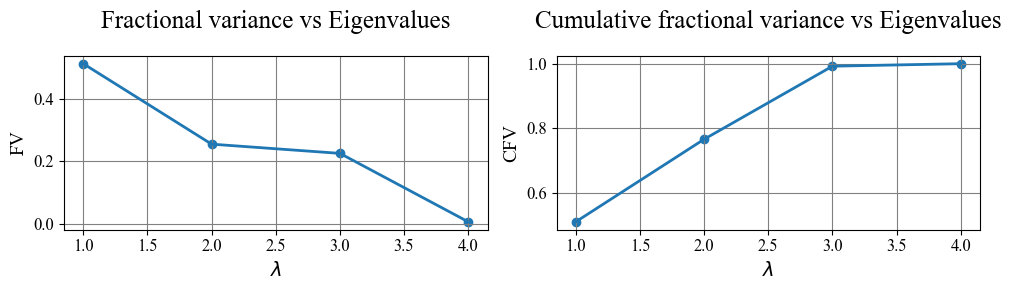

In [73]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)
ax.plot(np.arange(vecs.shape[0])+1, evals)
ax.scatter(np.arange(vecs.shape[0])+1, evals)
ax.set_title('Fractional variance vs Eigenvalues')
ax.set_ylabel('FV')
ax.set_xlabel(r'$\lambda$')

ax = fig.add_subplot(122)
ax.plot(np.arange(vecs.shape[0])+1, evals.cumsum())
ax.scatter(np.arange(vecs.shape[0])+1, evals.cumsum())
ax.set_title('Cumulative fractional variance vs Eigenvalues')
ax.set_ylabel('CFV')
ax.set_xlabel(r'$\lambda$')

Almost 80% of the information is contained in the first two features, namely T90 and T100

[]

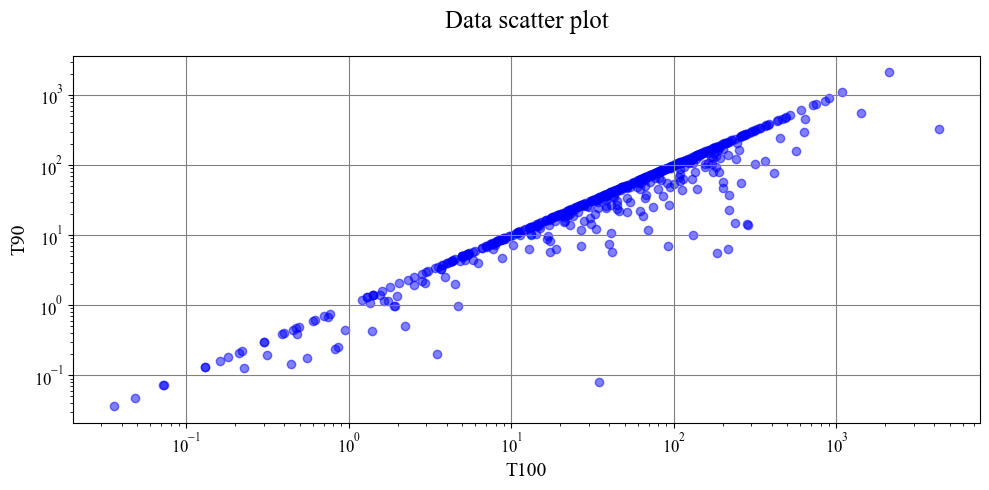

In [75]:
plt.scatter(T100, T90, marker='o', color='b', alpha=0.5)
plt.title('Data scatter plot')
plt.xlabel('T100')
plt.ylabel('T90')
plt.loglog()

In [76]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [93]:
S = np.vstack([np.log10(T90), np.log10(T100)]).T

In [94]:
S_train, S_test = train_test_split(S, test_size=0.2, random_state=42)

In [95]:
ns = np.arange(1,10,1)
aic = np.zeros_like(ns)
bic = np.zeros_like(ns)

In [96]:
for n in ns:
    GM = GaussianMixture(n_components=n)
    GM.fit(S_train)
    aic[n-min(ns)] = GM.aic(S_test)
    bic[n-min(ns)] = GM.bic(S_test)

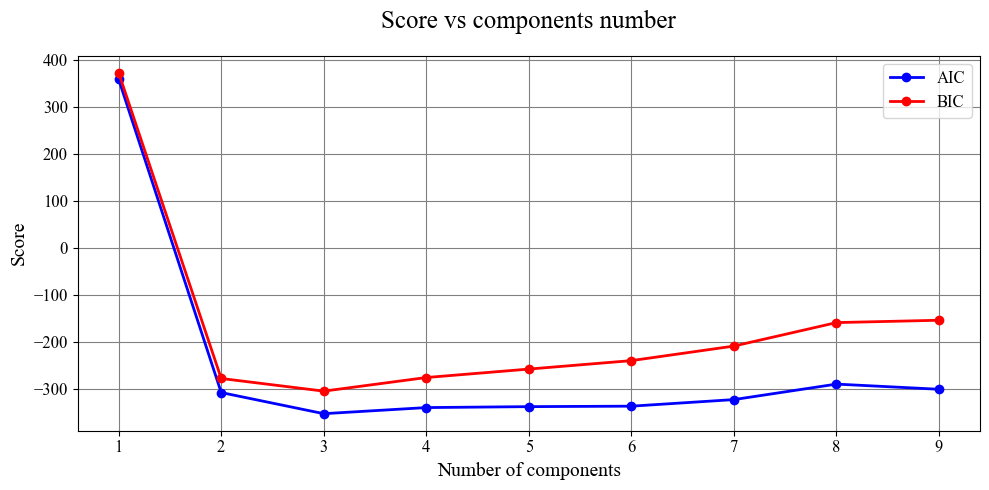

In [97]:
plt.plot(ns, aic, marker='o', color='blue', linewidth=2, label='AIC')
plt.plot(ns, bic, marker='o', color='red', linewidth=2, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('Score vs components number')
plt.legend()

In [98]:
GM = GaussianMixture(n_components=3)
GM.fit(S_train)

GaussianMixture(n_components=3)

In [99]:
from Utilities import utils

In [100]:
_ , model = utils.GM_fit(S_train, 3, False)

In [101]:
labels = model.predict(S_test)

In [102]:
centroids = model.means_
weights = model.weights_
ll = model.score_samples(S_test)

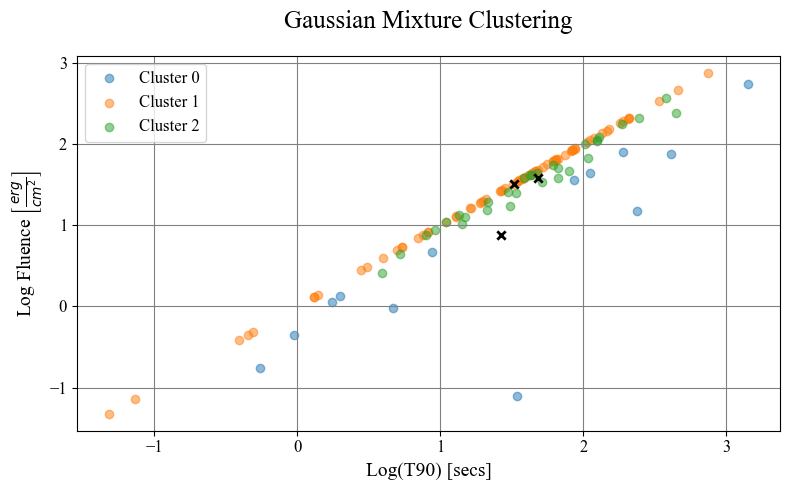

In [104]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()  

for i,c in enumerate(centroids):
    ax.scatter(S_test.T[1][labels==i],S_test.T[0][labels==i], marker='o', alpha=0.5, label=f'Cluster {i}')
    ax.scatter(c[1], c[0], marker='x', color='black')
    
ax.set_title('Gaussian Mixture Clustering')
ax.set_xlabel('Log(T90) [secs]')
ax.set_ylabel(r'Log Fluence $\left[\frac{erg}{cm^2}\right]$')
ax.legend()